In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import mchlearn

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["animation.html"] = "jshtml"

The wicked stepmother has ordered Cinderella to separate a mixture of different ingredients including _i.a._ lentils and ashes. The actual number of ingredients is unknown to poor Cinderella. Fortunately, Cinderella being good and kind has many friends. One of them working in "Birds inc." company lent her the newest model of "Dove" scanner that can measure the diameter of the particles. Using it Cinderella gathered a list containing the diameter of each particle in the mixture. Knowing that for each kind of particles the diameter distribution is normal, she separated the mixture into different ingredients.

Data gathered by  Cinderella can be found in file "data/mixture.txt"

In [2]:
data = np.loadtxt('mixture.txt')

In [3]:
data

array([1.15462038, 1.4846258 , 1.85954399, ..., 0.80692936, 1.117645  ,
       1.08439352])

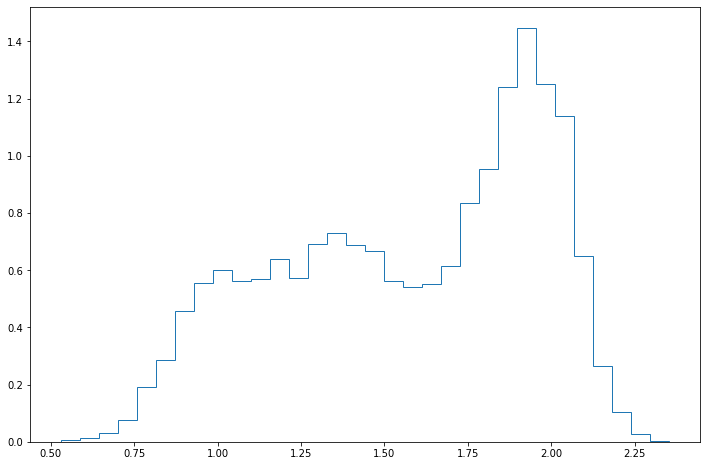

In [4]:
plt.hist(data,bins=32, histtype='step', density=True);

## Problem

In [5]:
from sklearn.mixture import GaussianMixture
from mchlearn.plotting import confidence_ellipse
from sklearn.model_selection import train_test_split



We can split the train and test set:

In [6]:
cindy_train, cindy_test = train_test_split(data, test_size=0.2)
cindy_train = cindy_train.reshape(-1, 1)
cindy_test = cindy_test.reshape(-1, 1)




We will test Gaussian mixtures up to 10 components, and we will evaluate which one is better using NLL, NLL with cross-validation, AIC and BIC: 

In [7]:
gmms = [GaussianMixture(n_components=i, tol=1e-4, max_iter=500, n_init=3) for i in range(1,11)] #preparing mixtures

In [8]:
from sklearn.model_selection import cross_validate



cvs =  [cross_validate(gm, cindy_train, y=None, cv=5) for gm in gmms] #cross-validating with ONLY the train set in this case.

In [9]:
for gm in gmms: #we must refit the mixtures. In this case, we only use the train set.
    gm.fit(cindy_train)

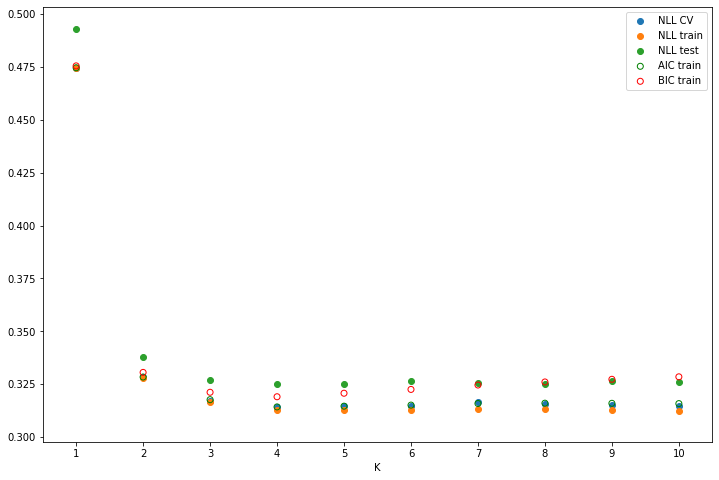

In [10]:
n_samples = len(cindy_train)
plt.scatter(np.arange(1,11), [-c['test_score'].mean() for c in cvs], label='NLL CV');
plt.scatter(np.arange(1,11), [-gm.score(cindy_train) for gm in gmms], label='NLL train');
plt.scatter(np.arange(1,11), [-gm.score(cindy_test) for gm in gmms], label='NLL test');
plt.scatter(np.arange(1,11), [0.5*gm.aic(cindy_train)/n_samples for gm in gmms], label='AIC train', facecolor='none', edgecolors='green');
plt.scatter(np.arange(1,11), [0.5*gm.bic(cindy_train)/n_samples for gm in gmms], label='BIC train', facecolor='none', edgecolors='red');
plt.xticks(np.arange(1,11));
plt.xlabel("K");
plt.legend();

In principle, for all criteria, the best is the one with the smallest value. In this case, we can see that from 2 to 10 component the difference is pretty small, and depending on the criterion we choose, the best number of components varies. I would say, that **the best mixture is the one with four components** (might make sense if we look at the histogram). 

In order to find the label of an item, we can calculate the distance of the item to the center of the clusters (the mean of each component of the mixture) and see which one is the smallest. In this case, since we are dealing with only one variable, we can just use **abs(item-center)** to calculate the distance.

In [17]:
labels=np.zeros(len(data))

centers = []

for i in range(len(data)): #we run through all the data
 item_label=[] #every time we run the first loop, the distances to the 4 centers will be appended here
 for j in range(4): #we check the distances to the 4 centers
   distance = abs(data[i]-gmms[3].means_[j])
   item_label.append(distance)
    
 labels[i] = np.argmin(item_label)  #the label is the position of the smallest element
 
      

We can present the results in a DataFrame

In [18]:
import pandas as pd

df= pd.DataFrame({'Data': data,'Labels': labels})
df.head(10)



,Data,Labels
0,1.154620,1.0
1,1.484626,3.0
2,1.859544,2.0
3,2.054004,0.0
4,2.071529,0.0
5,2.131497,0.0
6,1.773167,2.0
7,1.416441,3.0
8,1.129756,1.0
9,1.978357,0.0


We can check if this makes sense by looking at the centers:

In [19]:

print(gmms[3].means_)

[[1.97338258]
 [1.01648723]
 [1.75138622]
 [1.38255428]]


If we had two variables we could plot the items assigning them a color depending on how they were labeled and use the function confidence_ellipse, but this is not the case. What I will do instead is plot label vs data, which can be useful as well to visualize the clustering.

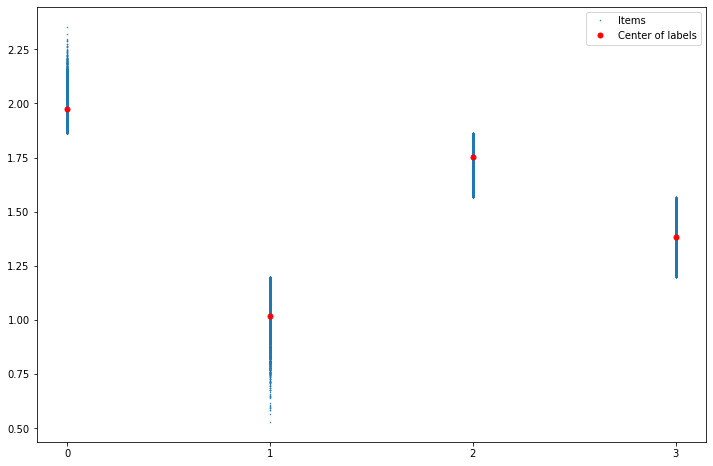

In [20]:
plt.plot(labels,data,marker= '.',markersize = 1,linestyle="None",label="Items")
plt.plot(np.arange(4),gmms[3].means_, markersize = 10,marker='.',color='red',linestyle="None", label = "Center of labels")
plt.legend()
plt.xticks(np.arange(min(labels), max(labels)+1, 1.0))
plt.show()

### Bonus question

Not knowing the real labels, how can you estimate  the accuracy of this classifier ? 

I cannot answer this question. As I didn't have any clue how to do it, I searched on Google and found two articles, but they seem a bit too complex to be the answer.